<a href="https://colab.research.google.com/gist/KhawajaMuddassar/3936841cfc35355cc5779a1a439b06e6/untitled0.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **What is CycleGAN?**
CycleGAN, which stands for Cycle-Consistent Generative Adversarial Network, is a variant of Generative Adversarial Networks (GANs) designed for unpaired image-to-image translation tasks. Unlike traditional GAN models, such as Pix2Pix, CycleGAN introduces a cycle-consistency loss, which represents a significant advancement. While standard GANs aim to learn a direct mapping between corresponding input and output domains—often effective when clear, consistent relationships exist between images—these models tend to struggle when such direct correspondences are ambiguous or absent.

The core concept behind CycleGAN and its cycle-consistency loss is to translate an image from domain A to domain B, and then map it back from domain B to domain A. The resulting image after this reverse transformation should closely resemble the original input. This cycle-consistency mechanism enables the model to learn meaningful relationships and capture semantic details between domains without requiring paired training data.

**CycleGAN Architecture:**
CycleGAN is composed of four main components: two generators and two discriminators. These components work together with adversarial loss, cycle consistency loss and Identity loss to perform image translation using unpaired image datasets.While there are several architectures present, the **Generator and Discriminator** can be made from various methods such as the **Attention mechanism, and U-Net**. However, the core concept of CycleGANs remains the same.

* **Adversarial loss:**This ensures that the both the domain generators accurately create objects in their respective domains using the other domain images as inputs.
* **Cycle loss:**The loss of recycling an image from the generated image to the original to ensure that the surrounding pixels are not changed.
* **Identity loss:** The loss when an input image of one class is passed through a generator that is expected to convert an image of another class into the class of the input image.

[CycleGAN Original Paper](https://arxiv.org/pdf/1703.10593)

# **Training CycleGAN:**

In [ ]:
!pip install -q --upgrade torch_snippets gdown torchsummary
import os, sys, torch, torchvision,itertools, gdown, zipfile, cv2, numpy as np, torch.nn as nn, time,glob
from glob import glob as Glob
from matplotlib import pyplot as plt
from PIL import Image
import ipywidgets as widgets
from IPython.display import display, clear_output
from torch.utils.data import Dataset, DataLoader
import torch.optim as optim
from torch_snippets.torch_loader import T, Report
from torch_snippets.loader import read, Blank, resize,show
from torch_snippets.bb_utils import randint
from sklearn.model_selection import train_test_split
from torchvision.transforms import ToPILImage
from torchsummary import summary
from ctypes import alignment
from torchvision import transforms as transforms
from torchvision.utils import make_grid
from torch.utils.data import random_split
from torch_snippets import *

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.6/78.6 kB 3.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 103.0/103.0 kB 7.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 82.7/82.7 kB 8.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 119.4/119.4 kB 11.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.6/61.6 kB 5.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 218.7/218.7 kB 20.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 162.6/162.6 kB 2.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.0/99.0 kB 9.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.3/4.3 MB 81.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 469.0/469.0 kB 24.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 67.9 MB/s eta 0:00:00


In [ ]:
class Preprocessor:
    def __init__(self, FileID='1syYOIQR55HwBVj1YOSpXERg-W2drGc7w'):
        self.FileID = FileID
        self.url = f'https://drive.google.com/uc?id={self.FileID}'
        self.Zipfile = 'CycleGAN.zip'
        self.TargetFolder = '/content/'
    def GetDataset(self):
        gdown.download(self.url, self.Zipfile, quiet=False)
        if not os.path.exists(self.TargetFolder):
            os.makedirs(self.TargetFolder)
    def Unzip(self):
        with zipfile.ZipFile(self.Zipfile, 'r') as zipref:
            zipref.extractall(self.TargetFolder)
            print(f'\nDataset downloaded and extracted successfully!')
    def RemoveZip(self):
        os.remove(self.Zipfile)
        print(f'Compressed file {self.Zipfile} removed!\n')
    def Run(self):
        self.GetDataset()
        self.Unzip()
        self.RemoveZip()

# Initialize Preprocessor
preprocessor = Preprocessor()

# Download Datasets
preprocessor.Run()

Downloading...
From (original): https://drive.google.com/uc?id=1syYOIQR55HwBVj1YOSpXERg-W2drGc7w
From (redirected): https://drive.google.com/uc?id=1syYOIQR55HwBVj1YOSpXERg-W2drGc7w&confirm=t&uuid=03b707df-d00d-48ff-8961-74bd675ffbc2
To: /content/CycleGAN.zip
100%|██████████| 1.25G/1.25G [00:16<00:00, 78.2MB/s]



Dataset downloaded and extracted successfully!
Compressed file CycleGAN.zip removed!



In [ ]:
class CategoryImageViewer:
    def __init__(self, root_path='/content/CycleGAN/', dataset=None):
        self.root_path = root_path
        self.dataset = dataset
        self.categories = self._get_categories()
        self.folder_paths = {category: os.path.join(self.root_path, category) for category in self.categories}
        self.data_splitter = None
        self.image_paths_A = None
        self.image_paths_B = None
        self.train_dl = None
        self.val_dl = None
        self.selected_categroy = None
        self.img_size = 128
        self.transform = transforms.Compose([
            transforms.Resize(int(self.img_size*1.33)),
            transforms.RandomCrop((self.img_size,self.img_size)),
            transforms.RandomHorizontalFlip(),
            transforms.ToTensor(),])
    def _get_categories(self):
        return [f.name for f in os.scandir(self.root_path) if f.is_dir()]
    def _get_image_paths(self, category_path, subfolder_name):
        subfolder_path = os.path.join(category_path, subfolder_name)
        image_paths = []
        for dirpath, _, filenames in os.walk(subfolder_path):
            for file_name in filenames:
                if file_name.lower().endswith(('.png', '.jpg', '.jpeg')):
                    image_paths.append(os.path.join(dirpath, file_name))
        return image_paths
    def _display_image_grid(self, category_path, subfolderA='trainA', subfolderB='trainB'):
        self.image_paths_A = self._get_image_paths(category_path, subfolderA)
        self.image_paths_B = self._get_image_paths(category_path, subfolderB)
        # Check if images are found
        if not self.image_paths_A or not self.image_paths_B:
            print(f"Error: No images found in {subfolderA} or {subfolderB}.")
            return
        num_images_A = min(25, len(self.image_paths_A))
        num_images_B = min(25, len(self.image_paths_B))
        selected_categroy = os.path.basename(category_path)
        self.selected_categroy = selected_categroy
        print(f"Selected Category: {os.path.basename(category_path)}")
        fig, axes = plt.subplots(2, 5, figsize=(5, 5),)
        for i, ax in enumerate(axes[0]):
            if i < num_images_A:
                image = Image.open(self.image_paths_A[i]).convert('RGB')
                image = self.transform(image)
                image = image.permute(1, 2, 0)
                ax.imshow(image)
                ax.axis('off')
            else:
                ax.axis('off')
        axes[0, 0].set_title(f"Images from {subfolderA}", fontsize=10)
        for i, ax in enumerate(axes[1]):
            if i < num_images_B:
                image = Image.open(self.image_paths_B[i]).convert('RGB')
                image = self.transform(image)
                image = image.permute(1, 2, 0)
                ax.imshow(image)
                ax.axis('off')
            else:
                ax.axis('off')
        axes[1, 0].set_title(f"Images from {subfolderB}", fontsize=10)
        plt.tight_layout(pad=0.0)
        plt.subplots_adjust(top=0.55, hspace=0.3)
        plt.show()
    def create_category_selector(self):
        category_dropdown = widgets.Dropdown(
            options=list(self.folder_paths.keys()),
            value=list(self.folder_paths.keys())[0],
            description='Select:',
            disabled=False, )
        instruction_label = widgets.Label(value="Please choose a category for image display:")
        def on_category_change(change):
            clear_output(wait=True)
            display(instruction_label)
            display(category_dropdown)
            category_input = change.new
            if category_input not in self.folder_paths:
                print(f"Category '{category_input}' not found!")
                return
            category_path = self.folder_paths[category_input]
            # Retrieve image paths before continuing
            self._display_image_grid(category_path)
            # Image paths
            if not self.image_paths_A or not self.image_paths_B:
                print("Error: Image paths are not set.")
                return
            # Create the CycleGANDataset instance with the paths
            dataset = CycleGANDataset(self.image_paths_A, self.image_paths_B)
            # Create DataSplit instance and pass the dataset
            self.data_splitter = DataSplit(dataset)
            # Create datasets and dataloaders using DataSplit
            self.data_splitter.create_datasets_and_dataloaders()
            # Retrieve dataloaders
            trn_dl, val_dl = self.data_splitter.get_dataloaders()
            self.train_dl = trn_dl
            self.val_dl = val_dl

        category_dropdown.observe(on_category_change, names='value')
        display(instruction_label)
        display(category_dropdown)

class CycleGANDataset(Dataset):
    def __init__(self, image_paths_A, image_paths_B):
        self.image_A = image_paths_A
        self.image_B = image_paths_B
        self.device = 'cuda' if torch.cuda.is_available() else 'cpu'
        self.img_size = 128
        self.transform = transforms.Compose([
            transforms.Resize(int(self.img_size*1.33)),
            transforms.RandomCrop((self.img_size,self.img_size)),
            transforms.RandomHorizontalFlip(),
            transforms.ToTensor(),
            transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),])
    def __getitem__(self, ix):
        image_A = self.image_A[ix % len(self.image_A)]
        image_B = self.image_B[ix % len(self.image_B)]
        image_A = Image.open(image_A).convert('RGB')
        image_B = Image.open(image_B).convert('RGB')
        return image_A, image_B
    def __len__(self):
        return max(len(self.image_A), len(self.image_B))
    def collate_fn(self, batch):
        srcs, trgs = list(zip(*batch))
        srcs = torch.cat([self.transform(img)[None] for img in srcs], 0).to(self.device).float()
        trgs = torch.cat([self.transform(img)[None] for img in trgs], 0).to(self.device).float()
        return srcs.to(self.device), trgs.to(self.device)

class DataSplit:
    def __init__(self, dataset, split_ratio=0.8, batch_size=16):
        self.dataset = dataset
        self.split_ratio = split_ratio
        self.batch_size = batch_size
        self.trn_ds = None
        self.val_ds = None
        self.trn_dl = None
        self.val_dl = None
    def _split_data(self):
        # Split the dataset into training and validation sets
        dataset_size = len(self.dataset)
        split_idx = int(self.split_ratio * dataset_size)
        # Create training and validation splits
        train_ds, val_ds = random_split(self.dataset, [split_idx, dataset_size - split_idx])
        return train_ds, val_ds
    def create_datasets_and_dataloaders(self):
        # Split the dataset into training and validation datasets
        train_ds, val_ds = self._split_data()
        self.trn_ds = train_ds
        self.val_ds = val_ds
        self.trn_dl = DataLoader(self.trn_ds, batch_size=self.batch_size, shuffle=True, collate_fn=self.dataset.collate_fn,drop_last=True)
        self.val_dl = DataLoader(self.val_ds, batch_size=self.batch_size, shuffle=False, collate_fn=self.dataset.collate_fn,drop_last=True)
        print(f"Training dataset: {len(self.trn_ds)} images")
        print(f"Validation dataset: {len(self.val_ds)} images")
    def get_dataloaders(self):
        return self.trn_dl, self.val_dl

class WeightsInitializer:
    @staticmethod
    def weights_init_normal(m):
        classname = m.__class__.__name__
        if classname.find("Conv") != -1:
            torch.nn.init.normal_(m.weight.data, 0.0, 0.02)
            if hasattr(m, "bias") and m.bias is not None:
                torch.nn.init.constant_(m.bias.data, 0.0)
        elif classname.find("BatchNorm2d") != -1:
            torch.nn.init.normal_(m.weight.data, 1.0, 0.02)
            torch.nn.init.constant_(m.bias.data, 0.0)

class CycleGANComponents:
    class ResidualBlock(nn.Module):
        def __init__(self, in_features):
            super(CycleGANComponents.ResidualBlock, self).__init__()
            self.block = nn.Sequential(
                nn.ReflectionPad2d(1),
                nn.Conv2d(in_features, in_features, 3),
                nn.InstanceNorm2d(in_features),
                nn.ReLU(inplace=True),
                nn.ReflectionPad2d(1),
                nn.Conv2d(in_features, in_features, 3),
                nn.InstanceNorm2d(in_features),)
        def forward(self, x):
            return x + self.block(x)

    class GeneratorResNet(nn.Module):
        def __init__(self, num_residual_blocks=9):
            super(CycleGANComponents.GeneratorResNet, self).__init__()
            out_features = 64
            channels = 3
            model = [
                nn.ReflectionPad2d(3),
                nn.Conv2d(channels, out_features, 7),
                nn.InstanceNorm2d(out_features),
                nn.ReLU(inplace=True),]
            in_features = out_features
            # Downsampling
            for _ in range(2):
                out_features *= 2
                model += [
                    nn.Conv2d(in_features, out_features, 3, stride=2, padding=1),
                    nn.InstanceNorm2d(out_features),
                    nn.ReLU(inplace=True),]
                in_features = out_features
            # Residual blocks
            for _ in range(num_residual_blocks):
                model += [CycleGANComponents.ResidualBlock(out_features)]
            # Upsampling
            for _ in range(2):
                out_features //= 2
                model += [
                    nn.Upsample(scale_factor=2),
                    nn.Conv2d(in_features, out_features, 3, stride=1, padding=1),
                    nn.InstanceNorm2d(out_features),
                    nn.ReLU(inplace=True),]
                in_features = out_features
            # Output layer
            model += [nn.ReflectionPad2d(channels), nn.Conv2d(out_features, channels, 7), nn.Tanh()]
            self.model = nn.Sequential(*model)
            self.apply(WeightsInitializer.weights_init_normal)
        def forward(self, x):
            return self.model(x)
    class Discriminator(nn.Module):
        def __init__(self):
            super(CycleGANComponents.Discriminator, self).__init__()
            channels = 3  # Input image channels
            def discriminator_block(in_filters, out_filters, normalize=True):
                """Returns downsampling layers of each discriminator block"""
                layers = [nn.Conv2d(in_filters, out_filters, 4, stride=2, padding=1)]
                if normalize:
                    layers.append(nn.InstanceNorm2d(out_filters))
                layers.append(nn.LeakyReLU(0.2, inplace=True))
                return layers
            self.model = nn.Sequential(
                *discriminator_block(channels, 64, normalize=False),
                *discriminator_block(64, 128),
                *discriminator_block(128, 256),
                nn.Conv2d(256, 1, 3, stride=1, padding=1)
                    )
            self.apply(WeightsInitializer.weights_init_normal)
        def forward(self, img):
            return self.model(img)

class CycleGANManager:
    def __init__(self, num_residual_blocks=9):
        self.device = 'cuda' if torch.cuda.is_available() else 'cpu'
        # Initialize the models (Generators and Discriminators)
        self.generator_AB = CycleGANComponents.GeneratorResNet(num_residual_blocks).to(self.device)
        self.generator_BA = CycleGANComponents.GeneratorResNet(num_residual_blocks).to(self.device)
        self.discriminator_A = CycleGANComponents.Discriminator().to(self.device)
        self.discriminator_B = CycleGANComponents.Discriminator().to(self.device)
    def forward(self, real_A, real_B):
        # Forward pass through the generators
        fake_B = self.generator_AB(real_A)
        fake_A = self.generator_BA(real_B)
        # Forward pass through the discriminators
        pred_fake_A = self.discriminator_A(fake_A)
        pred_real_A = self.discriminator_A(real_A)
        pred_fake_B = self.discriminator_B(fake_B)
        pred_real_B = self.discriminator_B(real_B)
        return fake_A, fake_B, pred_fake_A, pred_real_A, pred_fake_B, pred_real_B
    def initialize_weights(self):
        self.generator_AB.apply(WeightsInitializer.weights_init_normal)
        self.generator_BA.apply(WeightsInitializer.weights_init_normal)
        self.discriminator_A.apply(WeightsInitializer.weights_init_normal)
        self.discriminator_B.apply(WeightsInitializer.weights_init_normal)
    def get_models(self):
        return self.generator_AB, self.generator_BA, self.discriminator_A, self.discriminator_B

class CycleGANTrainer:
    def __init__(self, cycleGANManager, lambda_cyc=10.0, lambda_id=5.0, lr=0.0002, betas=(0.5, 0.999), device=None):
        self.device = device or ('cuda' if torch.cuda.is_available() else 'cpu')
        self.cycleGANManager = cycleGANManager
        self.G_AB = cycleGANManager.generator_AB
        self.G_BA = cycleGANManager.generator_BA
        self.D_A = cycleGANManager.discriminator_A
        self.D_B = cycleGANManager.discriminator_B
        # Define loss functions
        self.criterion_GAN = nn.MSELoss()  # Adversarial loss
        self.criterion_cycle = nn.L1Loss()  # Cycle consistency loss
        self.criterion_identity = nn.L1Loss()  # Identity loss
        # Define optimizers for Generators and Discriminators
        self.optimizer_G = torch.optim.Adam(itertools.chain(self.G_AB.parameters(), self.G_BA.parameters()), lr=lr, betas=betas)
        self.optimizer_D_A = torch.optim.Adam(self.D_A.parameters(), lr=lr, betas=betas)
        self.optimizer_D_B = torch.optim.Adam(self.D_B.parameters(), lr=lr, betas=betas)
        # Set lambda values for cycle and identity loss
        self.lambda_cyc = lambda_cyc
        self.lambda_id = lambda_id
        self.n_epochs = 50
        self.log = Report(self.n_epochs)

    def generator_train_step(self, GS, optimizer, real_A, real_B):
        self.G_AB, self.G_BA = GS
        optimizer.zero_grad()
        # Identity Loss
        loss_id_A = self.criterion_identity(self.G_BA(real_A), real_A)
        loss_id_B = self.criterion_identity(self.G_AB(real_B), real_B)
        # Total Identity Loss
        loss_identity = (loss_id_A + loss_id_B) / 2
        # Generate fake B from real A and fake A from real B
        fake_B = self.G_AB(real_A)
        fake_A = self.G_BA(real_B)
        # GAN Loss
        loss_GAN_AB = self.criterion_GAN(self.D_B(fake_B), torch.Tensor(np.ones((len(real_A), 1, 16, 16))).to(self.device))
        loss_GAN_BA = self.criterion_GAN(self.D_A(fake_A), torch.Tensor(np.ones((len(real_A), 1, 16, 16))).to(self.device))
        loss_GAN = (loss_GAN_AB + loss_GAN_BA) / 2
        # Cycle Consistency Loss
        recov_A = self.G_BA(fake_B)
        loss_cycle_A = self.criterion_cycle(recov_A, real_A)
        recov_B = self.G_AB(fake_A)
        loss_cycle_B = self.criterion_cycle(recov_B, real_B)
        loss_cycle = (loss_cycle_A + loss_cycle_B) / 2
        # Total Generator Loss
        loss_G = loss_GAN + self.lambda_cyc * loss_cycle + self.lambda_id * loss_identity
        loss_G.backward()
        # Step for the optimizer
        self.optimizer_G.step()
        return loss_G, loss_identity, loss_GAN, loss_cycle, fake_A, fake_B

    def discriminator_train_step(self,D, real_data, fake_data, optimizer):
        optimizer.zero_grad()
        # Discriminator A Loss (real and fake)
        loss_real = self.criterion_GAN(D(real_data), torch.Tensor(np.ones((len(real_data), 1, 16, 16))).to(self.device))
        loss_fake = self.criterion_GAN(D(fake_data.detach()), torch.Tensor(np.zeros((len(fake_data), 1, 16, 16))).to(self.device))
        loss_D = (loss_real + loss_fake) / 2
        # Backprop and step for the discriminators
        loss_D.backward()
        optimizer.step()
        return loss_D

    @torch.no_grad()
    def generate_sample_results(self, val_dl):
      data = next(iter(val_dl))
      self.G_AB.eval()
      self.G_BA.eval()
      real_A, real_B = data
      fake_B = self.G_AB(real_A)
      fake_A = self.G_BA(real_B)
      real_A_grid = make_grid(real_A, nrow=6, normalize=True)
      real_B_grid = make_grid(real_B, nrow=6, normalize=True)
      fake_A_grid = make_grid(fake_A, nrow=6, normalize=True)
      fake_B_grid = make_grid(fake_B, nrow=6, normalize=True)
      fig, axes = plt.subplots(2, 2, figsize=(10, 10))
      axes[0, 0].imshow(real_A_grid.detach().cpu().permute(1, 2, 0).numpy())
      axes[0, 0].axis('off')
      axes[0, 0].set_title("Real A", fontsize=12)
      axes[0, 1].imshow(fake_B_grid.detach().cpu().permute(1, 2, 0).numpy())
      axes[0, 1].axis('off')
      axes[0, 1].set_title("Fake B (Generated)", fontsize=12)
      axes[1, 0].imshow(real_B_grid.detach().cpu().permute(1, 2, 0).numpy())
      axes[1, 0].axis('off')
      axes[1, 0].set_title("Real B", fontsize=12)
      axes[1, 1].imshow(fake_A_grid.detach().cpu().permute(1, 2, 0).numpy())
      axes[1, 1].axis('off')
      axes[1, 1].set_title("Fake A (Generated)", fontsize=12)
      # Adjust layout and show the images
      plt.tight_layout(pad=0.0)
      plt.subplots_adjust(top=0.55, hspace=0.3)
      plt.show()
    # Train over number of EPOCHS
    def iterator(self,trn_dl):
        for epoch in range(self.n_epochs):
            N = len(trn_dl)
            for bx, batch in enumerate(trn_dl):
                if bx==0:
                    real_A, real_B = batch
                    loss_G, loss_identity, loss_GAN, loss_cycle, fake_A, fake_B = self.generator_train_step((self.G_AB,self.G_BA), self.optimizer_G, real_A, real_B)
                    loss_D_A = self.discriminator_train_step(self.D_A, real_A, fake_A, self.optimizer_D_A)
                    loss_D_B = self.discriminator_train_step(self.D_B, real_B, fake_B, self.optimizer_D_B)
                    loss_D = (loss_D_A + loss_D_B) / 2
                    self.log.record(epoch+(1+bx)/N, loss_D=loss_D.item(), loss_G=loss_G.item(),
                        loss_GAN=loss_GAN.item(), loss_cycle=loss_cycle.item(),
                        loss_identity=loss_identity.item(), end='\r')


            self.log.report_avgs(epoch+1)

Label(value='Please choose a category for image display:')

Dropdown(description='Select:', index=6, options=('Horse2Zebra', 'Vangogh2Photo', 'Monet2Photo', 'Apple2Orange…

Selected Category: Facades


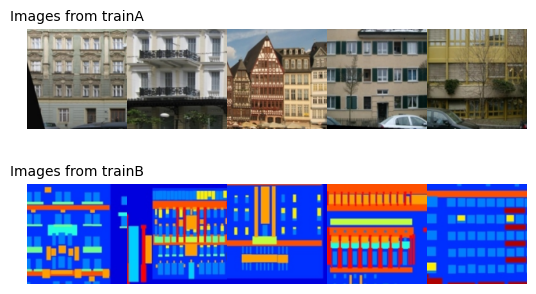

Training dataset: 320 images
Validation dataset: 80 images


In [ ]:
# Instance of CategoryImageViewer
viewer = CategoryImageViewer(root_path='/content/CycleGAN/')

# Category selector
viewer.create_category_selector()

EPOCH: 1.000  loss_GAN: 1.268  loss_G: 10.720  loss_identity: 0.621  loss_D: 0.791  loss_cycle: 0.635  (3.68s - 180.17s remaining)
EPOCH: 2.000  loss_GAN: 1.017  loss_G: 8.591  loss_identity: 0.463  loss_D: 0.777  loss_cycle: 0.526  (6.84s - 164.18s remaining)
EPOCH: 3.000  loss_GAN: 0.767  loss_G: 8.448  loss_identity: 0.434  loss_D: 0.598  loss_cycle: 0.551  (9.98s - 156.40s remaining)
EPOCH: 4.000  loss_GAN: 0.611  loss_G: 7.586  loss_identity: 0.397  loss_D: 0.523  loss_cycle: 0.499  (13.28s - 152.69s remaining)
EPOCH: 5.000  loss_GAN: 0.433  loss_G: 6.462  loss_identity: 0.359  loss_D: 0.411  loss_cycle: 0.424  (16.86s - 151.73s remaining)
EPOCH: 6.000  loss_GAN: 0.363  loss_G: 6.010  loss_identity: 0.347  loss_D: 0.369  loss_cycle: 0.391  (20.11s - 147.47s remaining)
EPOCH: 7.000  loss_GAN: 0.357  loss_G: 5.289  loss_identity: 0.310  loss_D: 0.357  loss_cycle: 0.338  (23.29s - 143.04s remaining)
EPOCH: 8.000  loss_GAN: 0.383  loss_G: 5.399  loss_identity: 0.304  loss_D: 0.333  lo

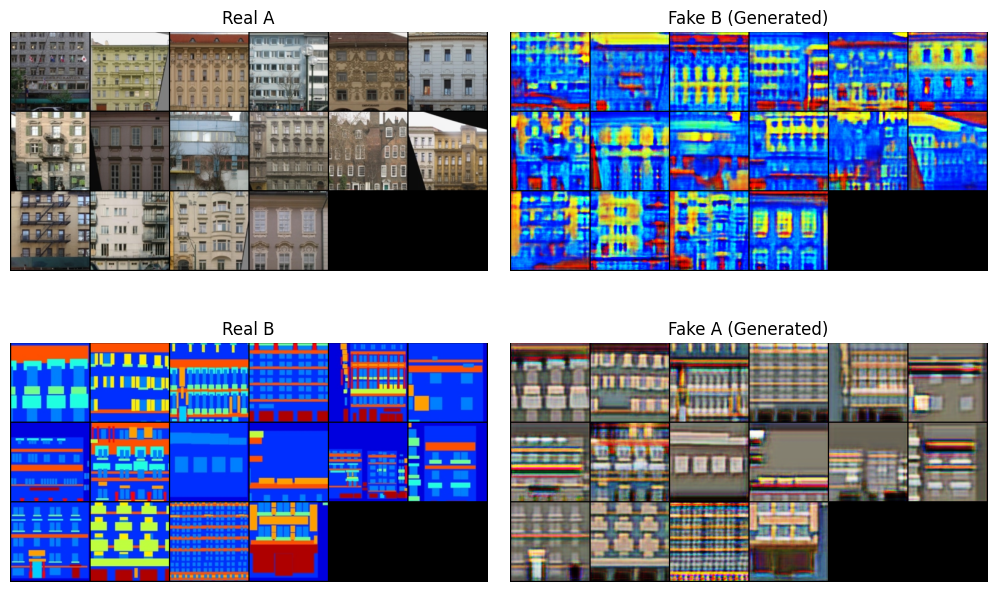

In [ ]:
# Dynamically expand memory segments during execution for better memory GPU utilization
os.environ['PYTORCH_CUDA_ALLOC_CONF'] = 'expandable_segments:True'

# CycleGAN Manager
cycle_gan_manager = CycleGANManager(num_residual_blocks=9)

# Weights Initialization for all models (generators and discriminators)
cycle_gan_manager.initialize_weights()

# Two batches of real images from domain A and domain B
real_A, real_B = next(iter(viewer.train_dl))

# Forward pass through the CycleGAN (both generators and discriminators)
fake_A, fake_B, pred_fake_A, pred_real_A, pred_fake_B, pred_real_B = cycle_gan_manager.forward(real_A, real_B)

# Train Network
trainer = CycleGANTrainer(cycle_gan_manager)
trainer.iterator(viewer.train_dl)
# Generate Sample
trainer.generate_sample_results(viewer.val_dl)